# Spacy : Test de Fine Tuning avec reprise d'entrainement pour la tâche de NER - 200000 data
## Stratégie
Entraînement d'un modèle SpaCy avec ajout des tags "ARR" et "DEP"

## Conclusion
Des problèmes d'alignements sur l'ensemble des données ne permettent pas d'obtenir des résultats pertinents 

## Importation et parametrage du modèle

In [14]:
# Chargement du modèle pré-entrainé
import spacy
spacy.prefer_gpu(0)
nlp = spacy.load("fr_core_news_sm")


In [15]:
# recuperation du pipeline NER
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe(ner, last=True)
else:
    ner = nlp.get_pipe("ner")


In [16]:
#Ajout des TAG d'entraînement au modèle (ARR, DEP)

resultArr = ner.add_label("ARR")
print(resultArr)
resultDep = ner.add_label("DEP")
print(resultDep)


1
1


## Importation et Préparation des données

In [17]:
import os
from datasets import load_dataset, DatasetDict, Dataset, concatenate_datasets

#Extraction du des données depuis les csv

path = "../../data/token_classification/"

# dataset dict with emtpy attribute train
dataset = DatasetDict({'train': Dataset.from_dict({})})

for file in os.listdir(path):
    if file.endswith(".csv"):
        new_data = load_dataset('csv', data_files=path + file, delimiter=';')
        dataset["train"] = concatenate_datasets([dataset["train"], new_data["train"]])

dataset["train"] = dataset["train"].remove_columns("ner_tags").remove_columns("tokens")
print(dataset["train"][0])

{'text': "Je souhaite organiser mon trajet pour me rendre chez Hedi, qui réside à HERRLISHEIM PRÈS COLMAR, en débutant depuis l'hopital de montereau fault yonne.", 'spacy_ner_tags': "[{'start': 74, 'end': 97, 'label': 'ARR'}, {'start': 131, 'end': 152, 'label': 'DEP'}]"}


In [18]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [19]:
show_random_elements(dataset["train"])

,text,spacy_ner_tags
0,Trouve un itinéraire de la place centrale de Villefranche Sur Saone à la place centrale de le lardin saint lazare.,"[{'start': 45, 'end': 67, 'label': 'DEP'}, {'start': 91, 'end': 113, 'label': 'ARR'}]"
1,Comment me rendre de Dinan à colomiers,"[{'start': 21, 'end': 26, 'label': 'DEP'}, {'start': 29, 'end': 38, 'label': 'ARR'}]"
2,Recherche le chemin le plus court entre vierzon et gien.,"[{'start': 40, 'end': 47, 'label': 'DEP'}, {'start': 51, 'end': 55, 'label': 'ARR'}]"
3,Je voudrais un billet BEAUVOIR SUR NIORT pauillac.,"[{'start': 22, 'end': 40, 'label': 'DEP'}, {'start': 41, 'end': 49, 'label': 'ARR'}]"
4,Montre-moi le chemin pour aller à la place centrale de Durtol à partir de la place centrale de Contrexéville.,"[{'start': 55, 'end': 61, 'label': 'ARR'}, {'start': 95, 'end': 108, 'label': 'DEP'}]"
5,Qu'est-ce que tu vas mettre ce soir ?,None
6,Pourrais-tu me donner les indications pour rejoindre HAVRE (LE ) depuis RAMBERVILLERS ?,"[{'start': 53, 'end': 64, 'label': 'ARR'}, {'start': 72, 'end': 85, 'label': 'DEP'}]"
7,"Je souhaite organiser mon trajet pour me rendre chez Idaline, qui réside à HERBITZHEIM, en débutant depuis SARREBOURG HÔPITAL","[{'start': 74, 'end': 85, 'label': 'ARR'}, {'start': 106, 'end': 124, 'label': 'DEP'}]"
8,"Je voudrais savoir comment me rendre à erstein depuis st-aignan-lep, s'il te plaît.","[{'start': 39, 'end': 46, 'label': 'ARR'}, {'start': 54, 'end': 67, 'label': 'DEP'}]"
9,J'espère que les prédictions de Tom sont fausses.,None


In [20]:
def is_entity_well_aligned(text, start, end):
    """Vérifie si l'entité est bien alignée dans le texte."""
    if start > 0 and text[start-1].isalnum():
        return False  # L'entité ne commence pas à une limite de mot
    if end < len(text) and text[end].isalnum():
        return False  # L'entité ne se termine pas à une limite de mot
    return True

In [21]:
import json
CONVERTED_TRAIN_DATA = []
misaligned_examples_count=0
print('Nombre total de lignes', len(dataset["train"]))
for item in dataset["train"]:
    text = item['text']
    spacy_ner_tags = item.get('spacy_ner_tags')  # Utilisation de get pour gérer les valeurs None

    if spacy_ner_tags not in (None, 'None', ''):
        annotations = json.loads(spacy_ner_tags.replace("'", '"'))
        if is_entity_well_aligned(text, annotations[0]['start'], annotations[0]['end']) and is_entity_well_aligned(text, annotations[0]['start'], annotations[0]['end']):
            entities = [(annotation['start'], annotation['end'], annotation['label']) for annotation in annotations]
            CONVERTED_TRAIN_DATA.append((text, {"entities": entities}))
    else:
        misaligned_examples_count += 1
        CONVERTED_TRAIN_DATA.append((text, {"entities": []}))


        
print(f"Nombre total d'exemples avec des entités mal alignées ignorés : {misaligned_examples_count}")



Nombre total de lignes 435710
Nombre total d'exemples avec des entités mal alignées ignorés : 41730


In [27]:
import spacy
from spacy.training import Example
import json

  # Remplacez "en" par le code de votre modèle linguistique
examples = []
print(CONVERTED_TRAIN_DATA[0])
misaligned_entities_count=0
for text, annots in CONVERTED_TRAIN_DATA:
    try:
        # Création d'un Doc pour le texte
        doc = nlp.make_doc(text)
        # Création de l'objet Example
        examples.append(Example.from_dict(doc, annots))
    except ValueError as e:
        misaligned_entities_count += 1
        break
                # Gestion des erreurs, par exemple des offsets mal alignés


# Affiche le total et un exemple pour vérification, si examples n'est pas vide
if examples:
    print('entités non allignées:', misaligned_entities_count)
    print('Total:', len(examples))
    print('Exemple :', examples[0])
    DATA = examples
else:
    print("Aucune donnée à afficher.")


("Je pars de Chouzé Sur Loire pour aller à l'aéroport de crepy en valois.", {'entities': [(11, 27, 'DEP'), (55, 70, 'ARR')]})
392296
entités non allignées: 0
Total: 392296
Exemple : {'doc_annotation': {'cats': {}, 'entities': ['O', 'O', 'O', 'B-DEP', 'I-DEP', 'L-DEP', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ARR', 'I-ARR', 'L-ARR', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['Je', 'pars', 'de', 'Chouzé', 'Sur', 'Loire', 'pour', 'aller', 'à', "l'", 'aéroport', 'de', 'crepy', 'en', 'valois', '.'], 'SPACY': [True, True, True, True, True, True, True, True, True, False, True, True, True, True, False, False], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'DEP': ['', '', ''

In [28]:
import random
from sklearn.model_selection import train_test_split

# Mélanger les données
random.shuffle(DATA)
DATA = DATA[0:200000]

# Division en 50% pour l'entraînement et 50% pour le test/validation
train_data, test_valid_data = train_test_split(DATA, test_size=0.5, random_state=42)

# Division du test/validation en deux parties égales : 25% pour le test et25% pour la validation
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state=42)

# train_data : 50% des données pour l'entraînement
# test_data : 25% des données pour le test
# valid_data : 25% des données pour la validation


In [25]:
#Desactivation des autres pipelines
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.resume_training()

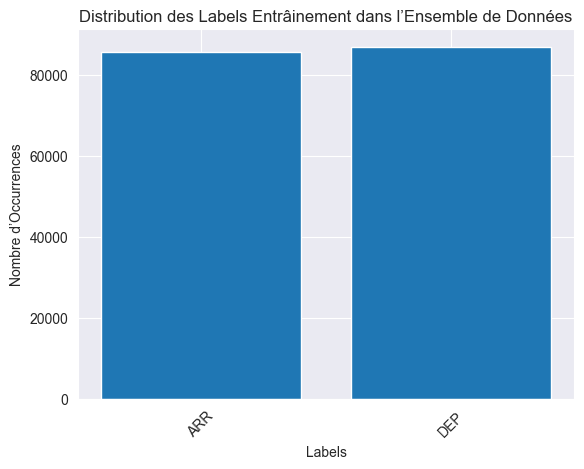

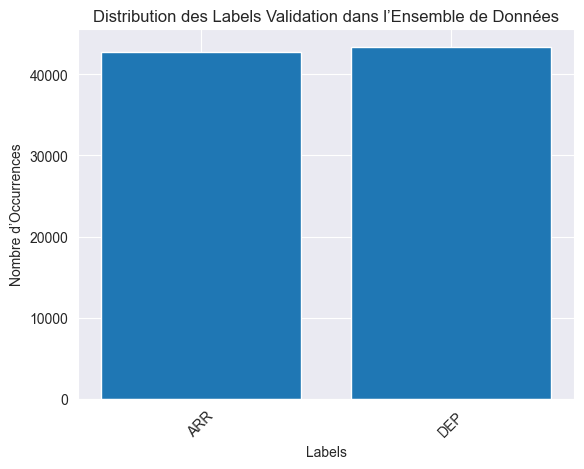

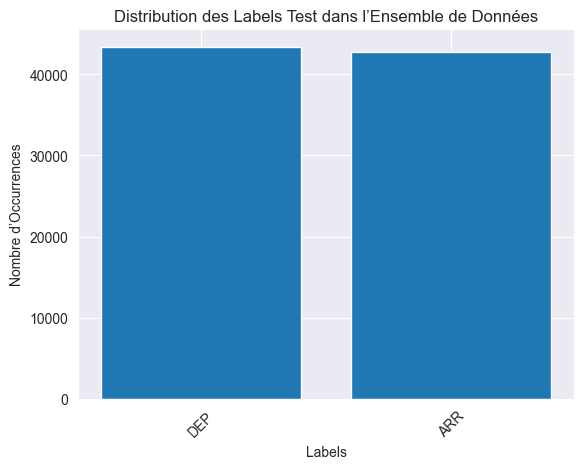

In [30]:
# Visualisation de la répartition des tag dans les données

import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(examples, label):
    # Compter les occurrences de chaque label
    label_counts = Counter([ent.label_ for example in examples for ent in example.y.ents])

    # Préparation des données pour le tracé
    labels, counts = zip(*label_counts.items())

    # Création du graphique à barres
    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Nombre d’Occurrences')
    plt.title('Distribution des Labels ' + label + ' dans l’Ensemble de Données')
    plt.xticks(rotation=45)
    plt.show()

plot_label_distribution(train_data, "Entrâinement")
plot_label_distribution(test_data, "Validation")
plot_label_distribution(valid_data, "Test")


## Entrainement

In [31]:
def draw_scores(f1_scores, recall_scores, accuracy_scores, losses_scores = None):
    plt.figure(figsize=(20, 10))  # Ajustez la taille du graphique selon vos besoins

    if(losses_scores is not None):
        # Graphique de la perte
        plt.subplot(2, 2, 1)
        plt.plot(losses_scores, marker='o', linestyle='-', color='blue')
        plt.xlabel('Itérations', fontsize=14)
        plt.ylabel('Perte', fontsize=14)
        plt.title('Perte durant l’entraînement', fontsize=16)
        plt.xticks(np.arange(0, len(losses_scores), step=1))  # Assurez-vous que l'axe x a des graduations entières

    # Graphique du score F1
    plt.subplot(2, 2, 2)
    plt.plot(f1_scores, marker='s', linestyle='-', color='green')
    plt.xlabel('Itérations', fontsize=14)
    plt.ylabel('Score F1', fontsize=14)
    plt.title('Score F1 sur l’ensemble de validation', fontsize=16)
    plt.xticks(np.arange(0, len(f1_scores), step=1))  # Répétez pour chaque graphique

    # Graphique du rappel
    plt.subplot(2, 2, 3)
    plt.plot(recall_scores, label='Rappel', marker='^', linestyle='-', color='red')
    plt.xlabel('Itérations', fontsize=14)
    plt.ylabel('Rappel', fontsize=14)
    plt.title('Rappel sur l’ensemble de validation', fontsize=16)
    plt.xticks(np.arange(0, len(recall_scores), step=1))

    # Graphique de la précision
    plt.subplot(2, 2, 4)
    plt.plot(accuracy_scores, label='Précision', marker='*', linestyle='-', color='purple')
    plt.xlabel('Itérations', fontsize=14)
    plt.ylabel('Précision', fontsize=14)
    plt.title('Précision sur l’ensemble de validation', fontsize=16)
    plt.xticks(np.arange(0, len(accuracy_scores), step=1))

    plt.tight_layout()  # Ajuste automatiquement les sous-graphiques pour qu'ils rentrent dans la figure
    plt.show()

Losses at iteration 0 : {'ner': 30354.771259828292}
Époque 0, F1 Score: 0.9946899573455591, F1 Score for ARR: 0.9948069225472921 F1 Score for DEP: 0.9945742519394163
Losses at iteration 1 : {'ner': 5526.145855455014}
Époque 1, F1 Score: 0.9974232188871092, F1 Score for ARR: 0.9971918657711838 F1 Score for DEP: 0.9976509062435227
Losses at iteration 2 : {'ner': 3360.429805310195}
Époque 2, F1 Score: 0.9985259468180183, F1 Score for ARR: 0.9983402295626155 F1 Score for DEP: 0.9987090825265099
Losses at iteration 3 : {'ner': 2387.5912509395666}
Époque 3, F1 Score: 0.9989146647939314, F1 Score for ARR: 0.9986801069930968 F1 Score for DEP: 0.9991463245812376
Losses at iteration 4 : {'ner': 1783.137439649931}
Époque 4, F1 Score: 0.9994484920611884, F1 Score for ARR: 0.9992636660082516 F1 Score for DEP: 0.9996308941589


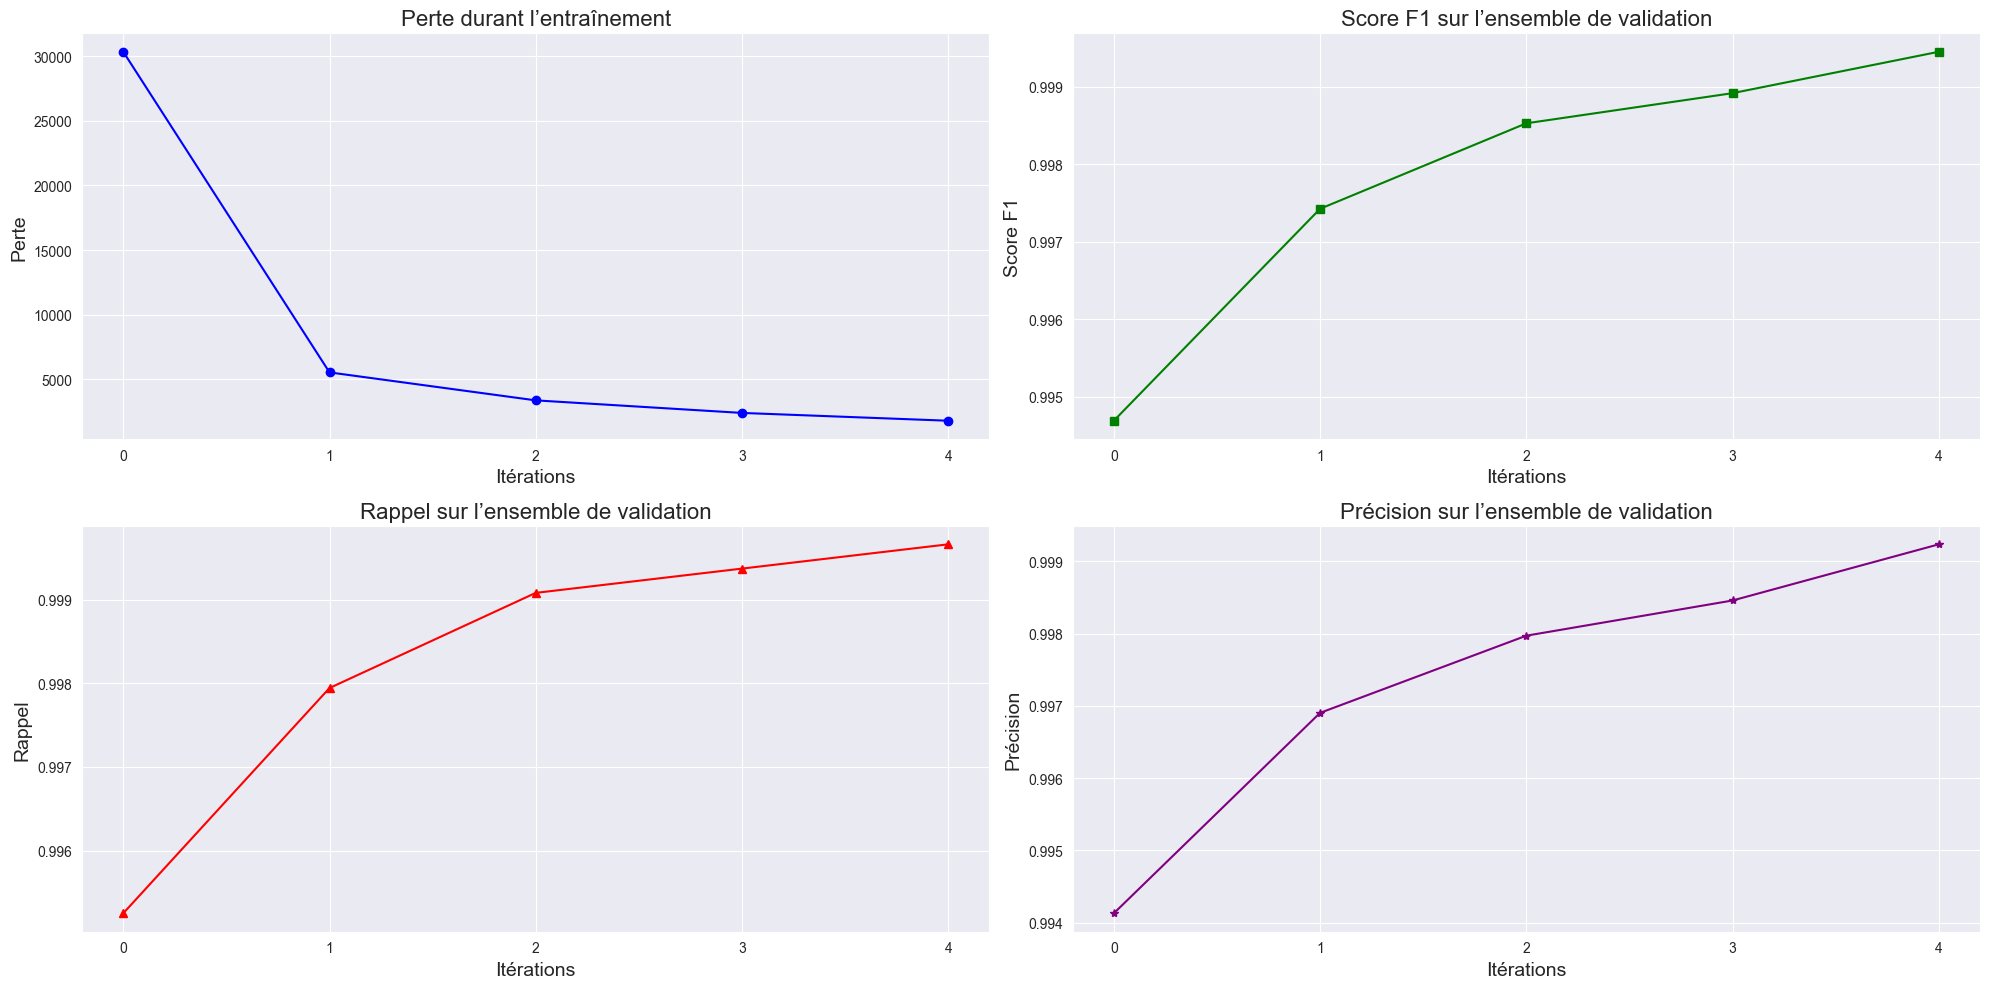

In [32]:
from spacy.scorer import Scorer
#Entrainement
import matplotlib.pyplot as plt
import random
from spacy.util import minibatch, compounding
from typing import Iterable
import numpy as np

def evaluate(nlp, examples: Iterable[Example]) -> dict:
    scorer = Scorer(nlp)  # Initialisation du Scorer avec le modèle spaCy
    examples_to_score = []
    for example in examples:
        pred_doc = nlp(example.text)  # Génération des prédictions pour le texte de l'exemple
        scored_example = Example(pred_doc, example.reference)  # Création d'un objet Example avec les prédictions
        examples_to_score.append(scored_example)
    scores = scorer.score(examples_to_score, per_component=False)  # Évaluation des exemples
    return scores

best_score = 0.0
no_improve_epochs = 0
max_no_improve_epochs = 3  # Nombre maximal d'époques sans amélioration

recall_scores = []
accuracy_scores = []
losses_scores = []
f1_scores = []

# Désactivation des autres pipelines pendant l'entraînement
with nlp.disable_pipes(*[pipe for pipe in nlp.pipe_names if pipe != "ner"]):
    optimizer = nlp.resume_training()  #nlp.begin_training()
    for i in range(5):  # Nombre d'itérations, ajustez selon vos besoins
        random.shuffle(train_data)
        losses = {}
        # Création de lots avec spaCy's minibatch et compounding
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            # Mise à jour du modèle avec les exemples du batch
            nlp.update(batch, drop=0.5, losses=losses, sgd=optimizer)
        print("Losses at iteration", i, ":", losses)
        losses_scores.append(losses['ner'])

        # Évaluation et collecte des métriques
        scores = evaluate(nlp, valid_data)
        # scores = evaluate(nlp, valid_examples)
        f1_score = scores['ents_f']
        arr_f1_score = scores['ents_per_type']['ARR']['f']
        dep_f1_score = scores['ents_per_type']['DEP']['f']
        f1_scores.append(f1_score)

        recall_score = scores['ents_r']
        precision_score = scores['ents_p']  # Précision utilisée comme approximation de l'accuracy dans ce contexte
        recall_scores.append(recall_score)
        accuracy_scores.append(precision_score)

        print(f"Époque {i}, F1 Score: {f1_score}, F1 Score for ARR: {arr_f1_score} F1 Score for DEP: {dep_f1_score}")

        # Early Stopping
        if f1_score > best_score:
            best_score = f1_score
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= max_no_improve_epochs:
            print(f"Arrêt précoce après {i} époques.")
            break


draw_scores(f1_scores, recall_scores, accuracy_scores, losses_scores)


In [33]:
from pathlib import Path

# Définir le répertoire courant comme emplacement de sauvegarde
output_dir = Path(".") / "pre_trained_spacy_model"

# Créer le dossier de sauvegarde s'il n'existe pas
output_dir.mkdir(parents=True, exist_ok=True)

# Sauvegarder le modèle spaCy dans le dossier créé
nlp.to_disk(output_dir)
print(f"Modèle sauvegardé dans {output_dir.absolute()}")


Modèle sauvegardé dans D:\EpitechProjects\T-AIA-901\T-AIA-901\ai\token-classification\spacy\pre_trained_spacy_model


## Evaluation

In [34]:
#Evaluation sur les données de test
test_scores = evaluate(nlp, test_data)

# Extraction des métriques
recall = round(test_scores['ents_r'], 4)
precision = round(test_scores['ents_p'], 4)
f1_score = round(test_scores['ents_f'], 4)

recall, precision, f1_score

(0.9609, 0.9616, 0.9612)

In [36]:
from collections import defaultdict
import pandas as pd

def calculate_ner_confusion_matrix(examples, nlp):
    # Initialisation des compteurs pour chaque type d'entité
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    false_negatives = defaultdict(int)

    for example in examples:
        # Texte original et annotations de référence
        text = example.text
        reference_ents = example.reference.ents

        # Prédiction du modèle
        pred_doc = nlp(text)
        pred_ents = pred_doc.ents

        # Conversion en sets pour faciliter la comparaison
        ref_set = {(ent.start_char, ent.end_char, ent.label_) for ent in reference_ents}
        pred_set = {(ent.start_char, ent.end_char, ent.label_) for ent in pred_ents}

        # Calcul des vrais positifs, faux positifs et faux négatifs
        for ent in pred_set:
            if ent in ref_set:
                true_positives[ent[2]] += 1
            else:
                false_positives[ent[2]] += 1

        for ent in ref_set:
            if ent not in pred_set:
                false_negatives[ent[2]] += 1

    return true_positives, false_positives, false_negatives

# Exemple d'utilisation
true_positives, false_positives, false_negatives = calculate_ner_confusion_matrix(test_data, nlp)


In [37]:
def display_confusion_matrix(true_positives, false_positives, false_negatives):
    # Création d'un DataFrame pour l'affichage
    labels = set(true_positives) | set(false_positives) | set(false_negatives)
    data = []
    for label in labels:
        tp = true_positives.get(label, 0)
        fp = false_positives.get(label, 0)
        fn = false_negatives.get(label, 0)
        data.append({"Label": label, "Vrais Positifs": tp, "Faux Positifs": fp, "Faux Négatifs": fn})

    df = pd.DataFrame(data)
    df.set_index("Label", inplace=True)
    print(df)

# Exemple d'affichage
display_confusion_matrix(true_positives, false_positives, false_negatives)


       Vrais Positifs  Faux Positifs  Faux Négatifs
Label                                              
ARR             41138           3224           1627
DEP             41612           3326           1740


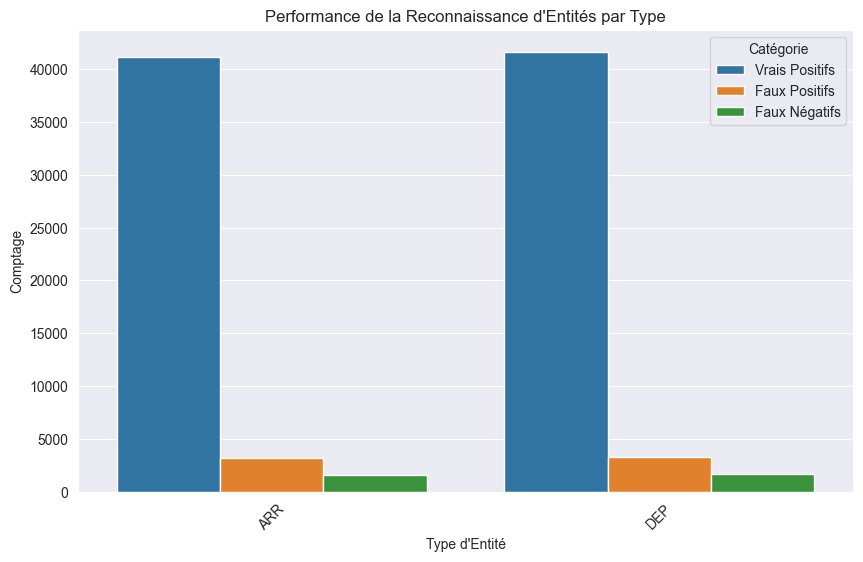

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Supposons que vous ayez déjà calculé true_positives, false_positives, et false_negatives

# Préparation des données pour la visualisation
data = {
    "Type d'Entité": [],
    "Comptage": [],
    "Catégorie": []
}
labels = set()
for example in test_data:
    for ent in example.reference.ents:
        labels.add(ent.label_)

# Ajouter les données de chaque catégorie pour chaque label
for label in labels:
    data["Type d'Entité"].extend([label]*3)
    data["Comptage"].extend([
        true_positives.get(label, 0),
        false_positives.get(label, 0),
        false_negatives.get(label, 0)
    ])
    data["Catégorie"].extend(["Vrais Positifs", "Faux Positifs", "Faux Négatifs"])

df = pd.DataFrame(data)

# Visualisation avec Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Type d'Entité", y="Comptage", hue="Catégorie", data=df)
plt.xticks(rotation=45)
plt.title("Performance de la Reconnaissance d'Entités par Type")
plt.show()


# Matrice de confusion

In [49]:
def get_locations_from_outputs(sentence, outputs):
    # Initialisation des listes pour stocker les localisations de départ et d'arrivée
    departures = []
    arrivals = []

    # Analyse des sorties pour extraire les entités pertinentes
    for output in outputs:
        # Exemple d'analyse basée sur les labels retournés par votre modèle
        if output['entity_group'] == 'DEP':  # Supposons que 'DEP' est le label pour les points de départ
            departures.append(output['word'])
        elif output['entity_group'] == 'ARR':  # Supposons que 'ARR' est le label pour les points d'arrivée
            arrivals.append(output['word'])

    # Retourne un dictionnaire avec les départ et arrivée identifiés
    return {'departures': departures, 'arrivals': arrivals}

def get_locations_from_doc(doc):
    departures = []
    arrivals = []

    for ent in doc.ents:
        
        if ent.label_ == "DEP":  # Assumer que 'DEP' est le label pour les points de départ
            departures.append(ent.text)
        elif ent.label_ == "ARR":  # Assumer que 'ARR' est le label pour les points d'arrivée
            arrivals.append(ent.text)

    return {"departures": departures, "arrivals": arrivals}


In [50]:
sentences = [
    "Je veux aller de Port-Boulet à Le Havre.",
    "Je veux aller de Port-Boulet au Havre.",
    "Je vais de Nantes à Paris.",
    "Je veux aller de Nantes à Nantes.",
    "Je vais à Port-Boulet en partant de Le Havre",
    "Je vais à Port-Boulet en partant du Havre",
    "Peux-tu m'aider à trouver mon chemin vers Paris en partant d'Épierre ?",
    "Je cherche un moyen d'aller de Margny-Lès-Compiègne à Saarbrücken /Sarrebruck.",
    "Je veux me rendre chez mon ami Etienne à Saint-Étienne depuis Nantes.",
    "Je veux aller de la ville de Marseille à Tours.",
    "Recherche le chemin le plus court entre la ville de Lorient et Paris",
    "Trouve-moi un itinéraire pour aller à Besançon depuis la ville d'Oyonnax.",
    "Ca met combien de temps un Toulouse Paris ?",
    "C'est quoi le trajet de Troyes à Niort ?",
    "Comment aller à Niort depuis Troyes ?",
    "Comment aller à Niort depuis Troyes",
    "Recherche un itinéraire de Nantes à Paris où habite Théo",
    "Trouve-moi le chemin le plus rapide vers Paris depuis Nantes pour arriver chez Michel.",
    "Il y a-t-il des trains de Nantes à Montaigu"
]

# Traitement des phrases avec le modèle spaCy et extraction des localisations
for sentence in sentences:
    doc = nlp(sentence)
    locations = get_locations_from_doc(doc)
    print(locations)


{'departures': ['Port-Boulet'], 'arrivals': ['Le Havre']}
{'departures': [], 'arrivals': []}
{'departures': ['Paris'], 'arrivals': ['Nantes']}
{'departures': [], 'arrivals': ['Nantes', 'Nantes']}
{'departures': ['Le Havre'], 'arrivals': []}
{'departures': [], 'arrivals': []}
{'departures': ['Paris', 'Épierre'], 'arrivals': []}
{'departures': ['Saarbrücken /Sarrebruck'], 'arrivals': ['Margny-Lès-Compiègne']}
{'departures': [], 'arrivals': ['Saint-Étienne', 'Nantes']}
{'departures': ['Tours'], 'arrivals': ['Marseille']}
{'departures': ['Lorient', 'Paris'], 'arrivals': []}
{'departures': [], 'arrivals': ['Besançon', 'Oyonnax']}
{'departures': ['Toulouse Paris'], 'arrivals': []}
{'departures': ['Troyes', 'Niort'], 'arrivals': []}
{'departures': ['Niort', 'Troyes'], 'arrivals': []}
{'departures': ['Niort', 'Troyes'], 'arrivals': []}
{'departures': ['Paris'], 'arrivals': ['Nantes']}
{'departures': ['Paris'], 'arrivals': ['Nantes']}
{'departures': [], 'arrivals': ['Nantes']}
